In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import base64
import string
import re
import nltk

from collections import Counter
from time import time
# from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS as stopwords
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt

from pywaffle import Waffle

from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('genesis')
nltk.download('wordnet')
nltk.download('omw-1.4')

In [ ]:
import requests

url = 'https://raw.githubusercontent.com/linogaliana/python-datascientist/master/content/course/NLP/get_data.py'
r = requests.get(url, allow_redirects=True)
open('getdata.py', 'wb').write(r.content)

import getdata



In [ ]:
train = getdata.create_train_dataframes()
train.head()

In [ ]:
fear_count = train.loc[train['Text'].str.contains('fear')].groupby('Author').agg('count')
print(fear_count)

In [ ]:
fig = plt.figure(
    FigureClass=Waffle,
    rows=15,  # Either rows or columns could be omitted
    values= fear_count['Text'] ,  # Pass a list of integers to values
    legend={'labels': list(fear_count.index)}
)
fig.savefig("plot.png", bbox_inches="tight")

In [ ]:
horror_count = train.loc[train['Text'].str.contains('horror')].groupby('Author').agg('count')
print(horror_count)

In [ ]:
fig = plt.figure(
    FigureClass=Waffle,
    rows=15,  # Either rows or columns could be omitted
    values=horror_count['Text'],  # Pass a list of integers to values
    legend={'labels': list(horror_count.index)}
)
fig.savefig("plot.png", bbox_inches="tight")

In [ ]:
authors = fear_count.index

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
for author in authors:
    text = train['Text'].loc[train['Author']==author]
    wc = WordCloud(collocations = False, background_color = 'white').generate(' '.join(text))

    fig = plt.figure()
    
    plt.imshow(wc, interpolation='bilinear')
   
    plt.axis("off")

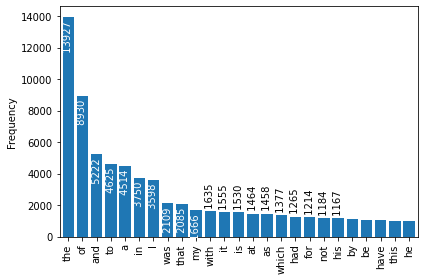

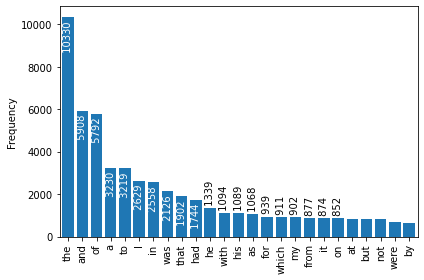

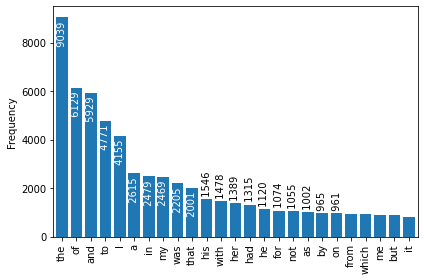

In [107]:
from collections import Counter
for author in authors:
    words = ' '.join(train.loc[train['Author']==author]['Text']).split(' ')
    tf = Counter(words)
    
    x = [x1[0] for x1 in tf.most_common(25)]
    y = [float(tf[x1]) for x1 in x]
    
    plt.bar(x, y)
    # plt.title("Term frequencies in" + author + "'s work")
    plt.ylabel("Frequency") # (log scale)
#     plt.yscale('log') # optionally set a log scale for the y-axis
    plt.xticks(rotation=90)
    for i, (tag, count) in enumerate(tf.most_common(20)):
        plt.text(i, count, f' {count} ', rotation=90,
                 ha='center', va='top' if i < 10 else 'bottom', color='white' if i < 10 else 'black')
    plt.xlim(-0.6, len(x)-0.4) # optionally set tighter x lims
    plt.tight_layout() # change the whitespace such that all labels fit nicely
    plt.show()

In [123]:
from nltk.tokenize import word_tokenize
stop = stopwords.words('english')
clean_train = train.copy()
tokenized_text = [word_tokenize(line) for line in train['Text']]
tokenized_text = [[word for word in line if (word.isalpha() and word not in stop)] for line in tokenized_text] # retirer stop words et caractères non alphanumériques
clean_train['Text'] = tokenized_text

In [141]:
from nltk.tokenize import word_tokenize
stop = stopwords.words('english')
clean_train = train.copy()
tokenized_text = train['Text'].apply(word_tokenize)
tokenized_text = tokenized_text.apply(lambda line1 : [x for x in line1 if (x.isalpha() and x not in stop)])
clean_train['Text'] = tokenized_text

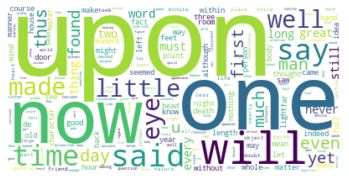

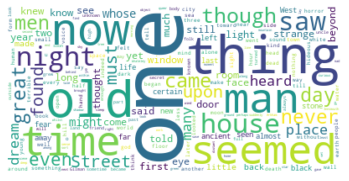

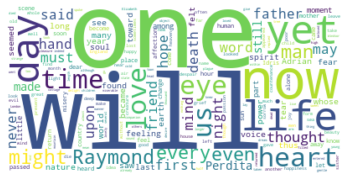

In [125]:
from collections import Counter
for author in authors:
    words = clean_train.loc[clean_train['Author']==author]['Text'].sum() # .sum() to concatenate all lists
    
    wc = WordCloud(collocations = False, background_color = 'white').generate(' '.join(words))

    fig = plt.figure()

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")

In [126]:
from nltk.stem import WordNetLemmatizer
lemm = WordNetLemmatizer()

for word in ["women","daughters", "leaves"]:
    print("The lemmatized form of %s is: {}".format(lemm.lemmatize(word)) % word)

The lemmatized form of women is: woman
The lemmatized form of daughters is: daughter
The lemmatized form of leaves is: leaf


In [145]:
lemm_train = clean_train.copy()
lemmatized_text = clean_train['Text'].apply( lambda line1 : [lemm.lemmatize(word) for word in line1])
lemm_train['Text'] = lemmatized_text

In [ ]:
# pour comparer
print(train.Text)

In [ ]:
print(clean_train.Text)

In [172]:
# fonction pour préparer le texte
def clean_text(text, remove_stop_words=False):
    cleaned_text = text.apply(lambda x: ' '.join([word for word in x.split() if word.isalpha()]))
    if remove_stop_words:
        cleaned_text = text.apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in (stop)]))
        
    cleaned_text.apply(lambda x: ' '.join([lemm.lemmatize(word) for word in x.split()]))
    return cleaned_text

cleaned_text = clean_text(train.Text)
# you don't HAVE to remove stop words before using tf-idf, either the function can do it already
# or stop words won't even have semantic meaning with tf-idf because of their frequent nature

In [ ]:
print(cleaned_text)

In [165]:
# A FAIRE (appliquer tf-idf au cleaned_text)
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
tfs = tfidf.fit_transform(lemm_train['Text'].apply(lambda list1 : ' '.join(list1)))



In [166]:
tfidf.get_feature_names_out()

array(['aaem', 'ab', 'aback', ..., 'zorry', 'zubmizzion', 'zuro'],
      dtype=object)

In [173]:
# dataframe recensant les score de chaque mot dans chaque phrase
tfidf_df = pd.DataFrame(tfs.toarray(), index=cleaned_text.index.values, columns=tfidf.get_feature_names())
tfidf_df.loc['Document Frequency'] = (tfidf_df > 0).sum() # ligne avec la somme de score d'un mot (juste pour voir sa présence dans le corpus)
print(tfidf_df)

e:\Eric\Simplon\NLP_aout2022\nlp\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


                    aaem   ab  aback  abaft  abandon  abandoned  abandoning  \
id26305              0.0  0.0    0.0    0.0      0.0   0.000000         0.0   
id17569              0.0  0.0    0.0    0.0      0.0   0.000000         0.0   
id11008              0.0  0.0    0.0    0.0      0.0   0.000000         0.0   
id27763              0.0  0.0    0.0    0.0      0.0   0.000000         0.0   
id12958              0.0  0.0    0.0    0.0      0.0   0.261659         0.0   
...                  ...  ...    ...    ...      ...        ...         ...   
id08973              0.0  0.0    0.0    0.0      0.0   0.000000         0.0   
id05267              0.0  0.0    0.0    0.0      0.0   0.000000         0.0   
id17513              0.0  0.0    0.0    0.0      0.0   0.000000         0.0   
id00393              0.0  0.0    0.0    0.0      0.0   0.000000         0.0   
Document Frequency   1.0  1.0    2.0    1.0     11.0  29.000000         3.0   

                    abandonment  abaout  abased  ..

In [174]:
# A FAIRE (trouver les lignes où les termes ayant la structure abandon sont non-nuls.)
tfidf_df.loc[tfidf_df['abandon']>0]

,aaem,ab,aback,abaft,abandon,abandoned,abandoning,abandonment,abaout,abased,...,zobnarian,zodiac,zodiacal,zoilus,zokkar,zone,zopyrus,zorry,zubmizzion,zuro
id03066,0.0,0.0,0.0,0.0,0.238043,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
id02992,0.0,0.0,0.0,0.0,0.286375,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
id14259,0.0,0.0,0.0,0.0,0.310844,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
id11549,0.0,0.0,0.0,0.0,0.371665,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
id20580,0.0,0.0,0.0,0.0,0.388693,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
id23267,0.0,0.0,0.0,0.0,0.391154,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
id02614,0.0,0.0,0.0,0.0,0.238142,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
id06121,0.0,0.0,0.0,0.0,0.387515,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
id21365,0.0,0.0,0.0,0.0,0.330124,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
id22938,0.0,0.0,0.0,0.0,0.352632,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [175]:
tfidf_df['Author'] = train['Author'] # on rajoute la colonne author pour retrouver à quel auteur appartient une séquence
print(tfidf_df)

                    aaem   ab  aback  abaft  abandon  abandoned  abandoning  \
id26305              0.0  0.0    0.0    0.0      0.0   0.000000         0.0   
id17569              0.0  0.0    0.0    0.0      0.0   0.000000         0.0   
id11008              0.0  0.0    0.0    0.0      0.0   0.000000         0.0   
id27763              0.0  0.0    0.0    0.0      0.0   0.000000         0.0   
id12958              0.0  0.0    0.0    0.0      0.0   0.261659         0.0   
...                  ...  ...    ...    ...      ...        ...         ...   
id08973              0.0  0.0    0.0    0.0      0.0   0.000000         0.0   
id05267              0.0  0.0    0.0    0.0      0.0   0.000000         0.0   
id17513              0.0  0.0    0.0    0.0      0.0   0.000000         0.0   
id00393              0.0  0.0    0.0    0.0      0.0   0.000000         0.0   
Document Frequency   1.0  1.0    2.0    1.0     11.0  29.000000         3.0   

                    abandonment  abaout  abased  ..

In [179]:
# A FAIRE (Trouver les 50 extraits où le score TF-IDF est le plus élevé et l’auteur associé.)
list_fear = tfidf_df.nlargest(n=50, columns=['fear'])

In [185]:
list_fear[['fear','Author']]
list_fear['Author'].value_counts()

MWS    22
HPL    16
EAP    11
Name: Author, dtype: int64

In [186]:
print(list_fear.groupby(by='Author').count())

        aaem  ab  aback  abaft  abandon  abandoned  abandoning  abandonment  \
Author                                                                        
EAP       11  11     11     11       11         11          11           11   
HPL       16  16     16     16       16         16          16           16   
MWS       22  22     22     22       22         22          22           22   

        abaout  abased  ...  zobnarian  zodiac  zodiacal  zoilus  zokkar  \
Author                  ...                                                
EAP         11      11  ...         11      11        11      11      11   
HPL         16      16  ...         16      16        16      16      16   
MWS         22      22  ...         22      22        22      22      22   

        zone  zopyrus  zorry  zubmizzion  zuro  
Author                                          
EAP       11       11     11          11    11  
HPL       16       16     16          16    16  
MWS       22       22     2

In [197]:
list_fear = list_fear.drop('Document Frequency') # on enlève cette ligne qui ne nous sert pas ici


In [201]:
print(train.loc[list_fear.index[:9]]['Text'])
# print(train.loc[list_fear.index[:9]]['Text'].values)


id03085                            Already she fears for us.
id19365                        We could not fear we did not.
id21042                        "And now I do not fear death.
id22562                    I smiled, for what had I to fear?
id09720                 Indeed I had no fear on her account.
id09240        I have not the slightest fear for the result.
id09809      "I fear you are right there," said the Prefect.
id19372                        Be of heart and fear nothing.
id06566    I went down to open it with a light heart, for...
Name: Text, dtype: object


In [221]:
print(text1[10])
Text(text1[10]).concordance('days')

['He', 'shall', 'find', 'I', 'feel', 'injuries', 'shall', 'learn', 'dread', 'revenge', 'A', 'days', 'arrived']
Displaying 1 of 1 matches:
injuries shall learn dread revenge A days arrived


In [224]:
Text(text1[2])

<Text: In left hand gold snuff box capered hill...>

In [230]:
# A FAIRE (Utiliser la méthode concordance pour afficher le contexte dans lequel apparaît le terme fear)

from nltk.text import Text
# text_corpus = Text(train['Text'])
# tokens = nltk.word_tokenize(text)

text1 = nltk.Text(tokenized_text.sum())
text1.concordance('fear')




KeyboardInterrupt: 

In [239]:
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures
from nltk.collocations import *

bigram_measures = nltk.collocations.BigramAssocMeasures()

# A FAIRE (utiliser BigramCollocationFinder pour construire l'objet finder qu'on va utiliser ensuite pour trouver les meilleurs collocation)
finder = BigramCollocationFinder.from_words(tokenized_text[0])

finder.nbest(bigram_measures.likelihood_ratio, 10)

[('This', 'process'),
 ('afforded', 'means'),
 ('ascertaining', 'dimensions'),
 ('aware', 'fact'),
 ('circuit', 'return'),
 ('dimensions', 'dungeon'),
 ('fact', 'perfectly'),
 ('however', 'afforded'),
 ('make', 'circuit'),
 ('means', 'ascertaining')]

In [ ]:
# A FAIRE (ne conserver que les bigrammes présents au moins 5 fois)
finder.nbest(bigram_measures.likelihood_ratio, 10)

In [ ]:
finder.apply_freq_filter(5)
# A FAIRE (utiliser une autre méthode que la vraisemblance (likelihood), ici jaccard)

In [ ]:
# A FAIRE (Ne s’intéresser qu’aux collocations qui concernent le mot fear)
# ici construire une lambda qui va filtrer les ngram n'ayant pas le mot 'love'
love_filter = lambda *w : 'love' not in w
finder.apply_ngram_filter(love_filter)
finder.nbest(bigram_measures.jaccard, 10)

In [ ]:
fear_filter = # A FAIRE (pareil qu'au dessus avec fear)
finder.apply_ngram_filter(fear_filter)
finder.nbest(bigram_measures.jaccard, 10)